## FreqPulse-VAE: A Frequency-Conditioned Variational Autoencoder for Pulsatile Signal Generation

In [1]:
import os
import numpy as np
import pandas as pd
import yaml
from tqdm import trange, tqdm
from functools import reduce
from scipy import stats


import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda, LSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.MainModel import *
from Utilities.Utilities import *
from Utilities.EvaluationModules import *
from Models.Losses import *

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

def read_yaml(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

#### Env setting

In [2]:
ConfigName = 'SKZFC_ART_50_800'


if 'ART' in ConfigName:
    LoadConfig = 'Config' + 'ART'
elif 'PLETH' in ConfigName:
    LoadConfig = 'Config' + 'PLETH'
elif 'II' in ConfigName:
    LoadConfig = 'Config' + 'II'
else:
    assert False, "Please verify if the data type is properly included in the name of the configuration. The configuration name should be structured as 'Config' + 'data type', such as ConfigART."

yaml_path = './Config/'+LoadConfig+'.yml'

SavePath = './Results/'
ConfigSet = read_yaml(yaml_path)

### Model related parameters
SigType = ConfigSet[ConfigName]['SigType']
LatDim = ConfigSet[ConfigName]['LatDim']
CompSize = ConfigSet[ConfigName]['CompSize']

MaskingRate = ConfigSet[ConfigName]['MaskingRate']
NoiseStd = ConfigSet[ConfigName]['NoiseStd']
MaskStd = ConfigSet[ConfigName]['MaskStd']
ReparaStd = ConfigSet[ConfigName]['ReparaStd']
FcLimit = ConfigSet[ConfigName]['FcLimit']
DecayH = ConfigSet[ConfigName]['DecayH']
DecayL = ConfigSet[ConfigName]['DecayL']


ModelName = ConfigName+'.hdf5'
### Model checkpoint
ModelSaveName = SavePath+ModelName


### Data

In [3]:
TrData = np.load('./Data/ProcessedData/Tr'+str(SigType)+'.npy')
ValData = np.load('./Data/ProcessedData/Val'+str(SigType)+'.npy')

SigDim = ValData.shape[1]
DataSize = ValData.shape[0]

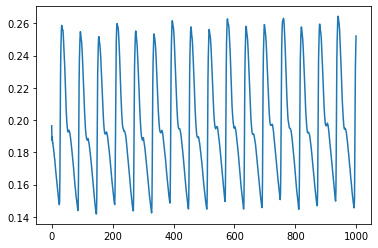

In [4]:
plt.plot(ValData[9])

### Post model

In [8]:
# Defining Modesl
EncModel = Encoder(SigDim=SigDim, LatDim= LatDim, Type = '', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = 1, Reparam=True, FcLimit=FcLimit)
FeatExtModel = FeatExtractor(SigDim=SigDim, CompSize = CompSize, DecayH=DecayH, DecayL=DecayL)
FeatGenModel = FeatGenerator(SigDim=SigDim,FeatDim=FeatExtModel.output[1].shape[-1], LatDim= LatDim)
ReconModel = Reconstructor(SigDim=SigDim, FeatDim=FeatExtModel.output[1].shape[-1])

Models = [EncModel,FeatExtModel,FeatGenModel,ReconModel] 

# Adding losses
SigRepModel = TCLosses(Models, DataSize, ConfigSet[ConfigName])


### Load weights
SigRepModel.load_weights(ModelSaveName)

### Regularizer resetting
for i in SigRepModel.weights:
    if i.name.split('/')[0] in ['Beta_Z','Beta_Fc','Beta_TC', 'Beta_MI' ,'Beta_Orig', 'Beta_Feat']:
        i.assign(1.)
        
## Model Compile
SigRepModel.compile(optimizer='adam') 
SigRepModel.summary()

OrigRecLoss added
FeatRecLoss added
kl_Loss_SKZ selected
kl_Loss_Z added
kl_Loss_FC added
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp_Enc (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame_7 (TFOpLambda)  (None, 20, 50)       0           Inp_Enc[0][0]                    
__________________________________________________________________________________________________
bidirectional_18 (Bidirectional (None, 20, 50)       11550       tf.signal.frame_7[0][0]          
__________________________________________________________________________________________________
bidirectional_19 (Bidirectional (None, 20, 50)       11550       bidirectional_18[0][0]           
__

In [151]:
SigGen_ZjFcAr.shape

(500, 100, 1000)

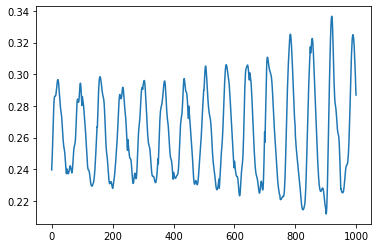

In [165]:
plt.plot(SigGen_ZjFcAr[0, 1])

In [166]:
Data= SigGen_ZjFcAr
### Conducting FFT 
HalfLen = Data.shape[-1]//2
FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen]) 
Amplitude = FFTRes/HalfLen
SelAmplitude = Amplitude[..., MinFreq:MaxFreq]
NFreq = SelAmplitude.shape[-1]

# The 0 frequency is excluded as it represents the constant term; by adding 1 to the index, the frequency and index can be aligned to be the same.
MaxAmplitudeLabel = np.argmax(SelAmplitude, axis=-1) + 1

### 분기
### Calculating mode values of MaxV_NG_ZFc; To index the max frequency, 1 is subtracted from the modes.
ModeMaxV_NG_ZFc = stats.mode(MaxAmplitudeLabel.T, axis=0, keepdims=False)[0] - 1

### (NMiniBat, Frequency_idx, NGen)
TransSelAmplitude = np.transpose(SelAmplitude, (0, 2,1))

#### Selecting variance values by the order of NMiniBat and Frequency_idx
#Var_ModeMaxV_NG_ZFc = np.var(TransSelAmplitude[np.arange(NMiniBat), ModeMaxV_NG_ZFc], axis=-1)
Amplitude_ModeMaxV_NG_ZFc = TransSelAmplitude[np.arange(NMiniBat), ModeMaxV_NG_ZFc]

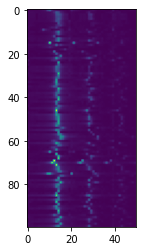

In [174]:
plt.imshow(SelAmplitude[0])

In [167]:
MaxAmplitudeLabel.shape

(500, 100)

In [168]:
# Power Spectral Density
PSD = ((NFreq*Amplitude_ModeMaxV_NG_ZFc)**2)/NGen
# Probability Density Function
PS_PDF = PSD / np.sum(PSD, axis=-1,keepdims=True)

# Power Spectral Entropy
PSE = np.sum(PS_PDF * np.log(PS_PDF), axis=-1)

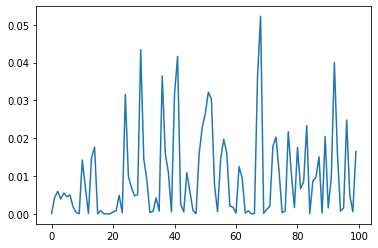

In [169]:
plt.plot(PS_PDF[0])

In [9]:
def ProbFreq (Data, NMiniBat, NGen, Axis, MeanZj=None, MinFreq = 1, MaxFreq = 51, EpsProb = 1e-7):

    ### Conducting FFT 
    HalfLen = Data.shape[-1]//2
    FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen]) 
    Amplitude = FFTRes/HalfLen
    SelAmplitude = Amplitude[..., MinFreq:MaxFreq]
    NFreq = SelAmplitude.shape[-1]
    ### Max Amplitude label
    MaxAmplitudeLabel = np.argmax(SelAmplitude, axis=-1) + 1
    MaxVLabelIDX =  np.arange(MaxFreq - MinFreq) + 1

    if Axis =='All':
        # The 0 frequency is excluded as it represents the constant term; by adding 1 to the index, the frequency and index can be aligned to be the same.
        MaxVLabelCount = np.zeros_like(MaxVLabelIDX)
        MaxV, Count = np.unique(MaxAmplitudeLabel, return_counts=True)
        MaxVLabelCount[MaxV] = Count

        ### Probability of frequencies 
        Prob = MaxVLabelCount / np.sum(MaxVLabelCount)

    elif Axis =='One':
        MaxVLabelCount = []
        MaxV_MeanZj = []
        # Mini batch-wise max freqeuncy count
        for num, mini in enumerate(MaxAmplitudeLabel):
            
            if MeanZj is not None:
                MeanZj = MeanZj.reshape(NMiniBat, NGen, -1)
                MaxV_MeanZj.append(np.mean(MeanZj[num], axis=0)[None]) 
                
            Count_ = np.zeros_like(MaxVLabelIDX)
            MaxV, Count = np.unique(mini, return_counts=True)
            Count_[MaxV] = Count
            MaxVLabelCount.append(Count_[None])

        # (Batch_size, N_frequency)
        MaxVLabelCount = np.concatenate(MaxVLabelCount)    
        Prob = MaxVLabelCount / NGen 
    
    if MeanZj is not None:
        return np.maximum(Prob, EpsProb), np.concatenate(MaxV_MeanZj)    
    else:
        return np.maximum(Prob, EpsProb)
    
    
def Sampler (Data):
    Z_Mu_Out = SigRepModel.get_layer('Z_Mu').output
    Zs_Out = SigRepModel.get_layer('Zs').output
    Z_Sigma_Out = SigRepModel.get_layer('Z_Log_Sigma').output
    FCs_Out = SigRepModel.get_layer('FCs').output
    Sampler = Model(EncModel.input, [Zs_Out, Z_Mu_Out, Z_Sigma_Out, FCs_Out])
    return Sampler.predict(Data, batch_size=2000, verbose=1)   

In [161]:
MaxFreq = 51
MinFreq = 1
NMiniBat = 500
SimSize = 1
MinFreqR=0.
MaxFreqR=0.05
NGen = 100
Ndata = len(ValData)
MASize = Ndata//NMiniBat
AnalData = ValData
NFCs = SigRepModel.get_layer('FCs').output.shape[-1]
NSelZ = 1

In [176]:
Mask_Z = np.zeros((NMiniBat, NGen, LatDim))

In [181]:
Samp_Z.reshape(NMiniBat, NGen, LatDim).shape

(500, 100, 50)

In [177]:
Mask_Z.shape

(500, 100, 50)

In [162]:
FC_Arange_ = np.tile(np.linspace(MinFreqR, MaxFreqR, NGen )[:, None], (1,NFCs))

### monte carlo approximation
I_V_Z = 0
I_V_ZjZ = 0
I_V_Zj = 0
I_V_ZjNF = 0
I_V_ZjFA = 0


for sim in range(SimSize):
    
    SplitData = np.array_split(AnalData, MASize)
    with trange(MASize, leave=False) as t:

        for mini in range(MASize):
            #print(sim, mini, MASize)
            
            # Masking for selecting Samp_Zj from Samp_Z by assuming Zs with indices other than j have mean values '0' of Guassian dist.
            Mask_Z = np.zeros((NMiniBat*NGen, LatDim))
            for i in range(NMiniBat*NGen):
                Mask_Z[i, np.random.choice(LatDim, NSelZ,replace=False )] = 1
            
            # Sampling
            print('Sampling Samp_Zs and Samp_Fc')
            SplitData_Ext =  np.broadcast_to(SplitData[mini][:, None], (NMiniBat, NGen, SplitData[mini].shape[-1])).reshape(-1, SplitData[mini].shape[-1])
            Samp_Z, Mu_Z, Sigma_Z, Samp_Fc = Sampler(SplitData_Ext)
            Samp_Zj = Samp_Z * Mask_Z
            
            # Reconstruction; y ~ P(Y | Z, Fc)
            print('Predicting SigGen_ZFc')
            FeatGen_ZFc = FeatGenModel.predict([Samp_Fc[:, :2],Samp_Fc[:, 2:], Samp_Z], batch_size=4000, verbose=1)
            SigGen_ZFc = ReconModel.predict([FeatGen_ZFc], batch_size=4000, verbose=1).reshape(NMiniBat, NGen, -1)
            
            # Reconstruction; y ~ P(Y | Zj, Fc); Assuming Zs with indices other than j have mean values '0' 
            print('Predicting SigGen_ZjFc')
            FeatGen_ZjFc = FeatGenModel.predict([Samp_Fc[:, :2],Samp_Fc[:, 2:], Samp_Zj], batch_size=4000, verbose=1)
            SigGen_ZjFc = ReconModel.predict([FeatGen_ZjFc], batch_size=4000, verbose=1).reshape(NMiniBat, NGen, -1)
            
            
            # ------------------------------------------------------------------------------------------------------------------- 
            # Reconstruction; y ~ P(Y | Zj); 
            # Assuming all FC values hvae mean values Mu_Fc * FcLimit <X∼Bern(x;μ=0.5) x FcLimit>, to eliminate the effect of Fc on signal generation.
            print('Predicting SigGen_Zj')
            Samp_Fc_Null = np.zeros_like(Samp_Fc) + FcLimit * 0.5
            FeatGen_Zj = FeatGenModel.predict([Samp_Fc_Null[:, :2], Samp_Fc_Null[:, 2:], Samp_Zj], batch_size=4000, verbose=1)
            SigGen_Zj = ReconModel.predict([FeatGen_Zj], batch_size=4000, verbose=1).reshape(NMiniBat, NGen, -1)
            
            # Reconstruction; y ~ P(Y | FcAr, Zj); 
            # The Fc values on FC_Arange (FcAr) are generated based on the linspace with a fixed interval.
            FC_Arange = np.broadcast_to(FC_Arange_[None], (NMiniBat, NGen, NFCs)).reshape(-1, NFCs)
            FeatGen_ZjFcAr = FeatGenModel.predict([FC_Arange[:, :2], FC_Arange[:, 2:], Samp_Zj], batch_size=4000, verbose=1)
            SigGen_ZjFcAr = ReconModel.predict([FeatGen_ZjFcAr], batch_size=4000, verbose=1).reshape(NMiniBat, NGen, -1)
                                    
            
            Q_V = ProbFreq (SigGen_ZFc, NMiniBat, NGen, 'All',  MinFreq = 1, MaxFreq = 51)
            Q_V_Z = ProbFreq (SigGen_ZFc, NMiniBat, NGen, 'One', MinFreq = 1, MaxFreq = 51)
            Q_V_Zj = ProbFreq (SigGen_ZjFc, NMiniBat, NGen,'One', MinFreq = 1, MaxFreq = 51)
            Q_V_Zj_NF = ProbFreq (SigGen_Zj, NMiniBat, NGen,'One', MinFreq = 1, MaxFreq = 51)
            Q_V_Zj_FA, MaxV_MeanZj = ProbFreq (SigGen_ZjFcAr, NMiniBat, NGen,'One', MeanZj=Samp_Zj, MinFreq = 1, MaxFreq = 51)
            
            
            # I(V;Z)
            I_V_Z_ = np.mean(np.sum(Q_V_Z * np.log(Q_V_Z / Q_V[None]), axis=-1))
            print('I_V_Z : ', I_V_Z_)
            I_V_Z += I_V_Z_
            
            # I(V;Zj|Z)
            I_V_ZjZ_ = np.mean(np.sum(Q_V_Zj * np.log(Q_V_Zj / Q_V_Z), axis=-1))
            print('I_V_ZjZ : ', I_V_ZjZ_)
            I_V_ZjZ += I_V_ZjZ_
            
            # I(V;Zj)
            I_V_ZjNF_ = np.mean(np.sum(Q_V_Zj_NF * np.log(Q_V_Zj_NF / Q_V), axis=-1))
            print('I_V_ZjNF : ', I_V_ZjNF_)
            I_V_ZjNF += I_V_ZjNF_
            
            # I(V;FC|Zj)
            I_V_ZjFA_ = np.mean(np.sum(Q_V_Zj_FA * np.log(Q_V_Zj_FA / Q_V_Zj_NF), axis=-1))
            print('I_V_ZjFA : ', I_V_ZjFA_)
            I_V_ZjFA += I_V_ZjFA_
            
            
            t.update(1)


I_V_Z /= (MASize*SimSize)
I_V_ZjZ /= (MASize*SimSize)

# CMI(V;Zj, Z)
CMI_V_ZjZ = I_V_Z + I_V_ZjZ             

  0%|                                                                                          | 0/120 [00:00<?, ?it/s]

Sampling Samp_Zs and Samp_Fc
25/25 [==============================] - 10s 351ms/step
Predicting SigGen_ZFc
13/13 [==============================] - 11s 812ms/step
Predicting SigGen_ZjFc
13/13 [==============================] - 10s 806ms/step
Predicting SigGen_Zj
13/13 [==============================] - 10s 761ms/step


  1%|▋                                                                              | 1/120 [01:50<3:38:40, 110.26s/it]

I_V_Z :  0.2284535067961292
I_V_ZjZ :  2.170678678407862
I_V_ZjNF :  1.4505763948799426
I_V_ZjFA :  0.10106144528226872
Sampling Samp_Zs and Samp_Fc
25/25 [==============================] - 9s 291ms/step
Predicting SigGen_ZFc
13/13 [==============================] - 9s 706ms/step
Predicting SigGen_ZjFc
13/13 [==============================] - 9s 701ms/step
Predicting SigGen_Zj
13/13 [==============================] - 9s 680ms/step


  2%|█▎                                                                             | 2/120 [03:27<3:21:25, 102.42s/it]

I_V_Z :  0.22806128289681296
I_V_ZjZ :  2.2769738608477574
I_V_ZjNF :  1.470338371355032
I_V_ZjFA :  0.11717014602531864
Sampling Samp_Zs and Samp_Fc
25/25 [==============================] - 10s 279ms/step
Predicting SigGen_ZFc
13/13 [==============================] - 9s 679ms/step
Predicting SigGen_ZjFc
13/13 [==============================] - 9s 682ms/step
Predicting SigGen_Zj
 4/13 [========>.....................] - ETA: 6s

KeyboardInterrupt: 

In [124]:
Samp_Zj[4]

array([ 0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -1.91953146,  0.        , -1.2590642 , -0.        ,  0.        ,
       -0.        ,  1.43195307, -0.        ,  0.        ,  0.88287216,
        0.02773528, -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.06705737,
        0.07446301, -0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.08684281,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ])

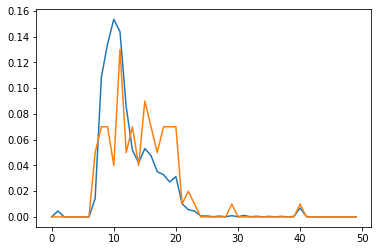

In [131]:
plt.plot(Q_V)
plt.plot(Q_V_Zj_FA[3])



In [ ]:
            Q_V   Q_V_Z Q_V_Zj  Q_V_Zj_NF Q_V_Zj_FA

In [42]:
MaxV_MeanZj[0]

array([ 0.        ,  0.00142618, -0.04591468, -0.03858455, -0.01835428,
        0.009306  , -0.02544727,  0.        , -0.00180658,  0.01909471,
       -0.01572306,  0.00656073,  0.01877734, -0.003918  ,  0.00948862,
       -0.00496202, -0.01715618, -0.02395445,  0.00340425, -0.01056157,
        0.01003529, -0.01603608, -0.01233093,  0.        ,  0.03623306,
        0.00828983,  0.00570921,  0.01190912,  0.00627315,  0.00014227,
        0.01078728,  0.00423105, -0.00545136, -0.0072295 ,  0.04677336,
       -0.02912462, -0.03282393,  0.00612001,  0.0079564 , -0.00983884,
        0.00212223,  0.00098124,  0.        ,  0.00186495, -0.00172255,
       -0.00828432,  0.00236936,  0.00925105,  0.00825056, -0.01940368])

In [29]:
MaxV_MeanZj.shape

(500, 50)

(500, 50)

In [97]:
Samp_Zj3d=None

In [24]:
MaxVLabelCount = []
MaxV_MeanZj = []
# Mini batch-wise max freqeuncy count
for num, mini in enumerate(MaxAmplitudeLabel):

    if MeanZj is not None:
        #MeanZj = MeanZj.reshape(NMiniBat, NGen, -1)
        MaxV_MeanZj.append(np.mean(MeanZj[num], axis=0)) 


NameError: name 'MeanZj' is not defined

In [89]:
Samp_Zj3d.shape, MaxAmplitudeLabel.shape, mini.shape, MaxV.shape, Count_.shape

((500, 100, 50), (500, 100), (100,), (9,), (50,))

In [101]:
MeanZj = Samp_Zj.reshape(NMiniBat, NGen, -1)
MeanZj = np.mean(MeanZj[num], axis=0)

In [21]:
MeanZj

NameError: name 'MeanZj' is not defined

(500, 100)

In [23]:
Data = SigGen_ZjFcAr

### Conducting FFT 
HalfLen = Data.shape[-1]//2
FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen]) 
Amplitude = FFTRes/HalfLen
SelAmplitude = Amplitude[..., MinFreq:MaxFreq]
NFreq = SelAmplitude.shape[-1]
### Max Amplitude label
MaxAmplitudeLabel = np.argmax(SelAmplitude, axis=-1) + 1
MaxVLabelIDX =  np.arange(MaxFreq - MinFreq) + 1

In [32]:
MaxVLabelCount = np.zeros_like(MaxVLabelIDX)
MaxV, Count = np.unique(MaxAmplitudeLabel, return_counts=True)
MaxVLabelCount[MaxV] = Count

In [36]:
MaxVLabelCount.shape

(50,)

In [37]:
MaxVLabelCount

array([    0,    11,     0,     0,     0,     0,     0,    13,   119,
         100,   379,  1087,  1135,  4947, 14950, 19697,  5467,  1302,
         400,   110,    84,    26,     9,     7,     0,     0,     0,
           0,     0,     4,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     1,   150,     2,     0,     0,     0,
           0,     0,     0,     0,     0])

In [13]:
AnalData = ValData

MaxFreq = 51
MinFreq = 1
NMiniBat = 100
SimSize = 1
MinFreqR=0.
MaxFreqR=0.05
NGen = 300
Ndata = len(ValData)
MASize = Ndata//NMiniBat

FC_Comm = np.tile(np.linspace(MinFreqR, MaxFreqR, NGen )[:, None], (1,2))
FC_Each = np.tile(np.linspace(MinFreqR, MaxFreqR, NGen )[:, None], (1,4))


# P_V
P_V = ProbFreq (AnalData, NMiniBat, NGen, MinFreq = 1, MaxFreq = 51)

### monte carlo approximation
I_V_Z = 0
I_VFc_Z = 0

for sim in range(SimSize):
    
    SplitData = np.array_split(AnalData, MASize)
    with trange(MASize, leave=False) as t:

        for mini in range(MASize):
            #print(sim, mini, MASize)
            
            P_V = ProbFreq (SplitData[mini], NMiniBat, NGen, MinFreq = 1, MaxFreq = 51)
            
            Mask_Z = np.zeros((NMiniBat, LatDim))
            for i in range(NMiniBat):
                Mask_Z[i, np.random.choice(LatDim)] = 1

            # Sampling
            print('Sampling Samp_Zs and FCs_Z')
            Samp_Zs, FCs_Z = Sampler(SplitData[mini])
            Samp_Zs *= Mask_Z
            
            # To eliminate the effect of Fc on signal generation, the Fc_Mu = 0.5 is given as a constant.
            FCs_Z[:, :] = FcLimit * 0.5
            FC_Comm_Z = FCs_Z[:, :2]
            FC_Each_Z  = FCs_Z[:, 2:]

            # I(V;z)
            print('Predicting SigGen_Z')
            FeatGen_Z = FeatGenModel.predict([FC_Comm_Z,FC_Each_Z, Samp_Zs], batch_size=4000, verbose=1)
            SigGen_Z = ReconModel.predict([FeatGen_Z], batch_size=4000, verbose=1)
            Q_V_Z = ProbFreq (SigGen_Z, NMiniBat, NGen, MinFreq = 1, MaxFreq = 51)
            # I(V;z)
            I_V_Z_ = np.sum(Q_V_Z * np.log(Q_V_Z / P_V))
            print('I_V_Z : ', I_V_Z_)
            I_V_Z += I_V_Z_


            # Expanding the data dimension for signal generation(random sampling) based on the frequency component (FC) 
            Samp_Zs_Ext =  np.broadcast_to(Samp_Zs[:, None], (NMiniBat, NGen, LatDim)).reshape(-1, LatDim)
            FC_Comm_Ext =  np.broadcast_to(FC_Comm[None], (NMiniBat, NGen, FC_Comm.shape[-1])).reshape(-1, FC_Comm.shape[-1])
            FC_Each_Ext =  np.broadcast_to(FC_Each[None], ( NMiniBat, NGen, FC_Each.shape[-1])).reshape(-1, FC_Each.shape[-1])

            # Q_V_ZFc
            print('Predicting SigGen_ZFc')
            FeatGen_ZFc = FeatGenModel.predict([FC_Comm_Ext,FC_Each_Ext, Samp_Zs_Ext], batch_size=4000, verbose=1)
            SigGen_ZFc = ReconModel.predict([FeatGen_ZFc], batch_size=4000, verbose=1).reshape(NMiniBat, NGen, -1)
            #SigGen_ZFc = SigGen_ZFc.reshape(NMiniBat*NGen, -1)
            Q_V_ZFc =ProbFreq (SigGen_ZFc, NMiniBat, NGen,  MinFreq = MinFreq, MaxFreq = MaxFreq)

            # I(V;Fc|z)
            I_VFc_Z_ = np.sum(Q_V_ZFc * np.log(Q_V_ZFc / Q_V_Z))
            print('I_VFc_Z : ', I_VFc_Z_)
            I_VFc_Z += I_VFc_Z_
            
            t.update(1)

I_V_Z /= (MASize*SimSize)
I_VFc_Z /= (MASize*SimSize)

I_V_z + I_VFc_z 

  0%|                                                                                          | 0/600 [00:00<?, ?it/s]

Sampling Samp_Zs and FCs_Z
1/1 [==============================] - 2s 2s/step


ValueError: too many values to unpack (expected 2)

In [ ]:
Mean.shape

In [5]:
def LogNormalDensity(LatSamp, LatMean, LogSquaScale):
    print(LatSamp.shape, LatMean.shape, LogSquaScale.shape)
    Norm = tf.math.log(2. * tf.constant(np.pi))
    InvSigma = tf.math.exp(-LogSquaScale)
    MeanSampDiff = (LatSamp - LatMean)
    return -0.5 * (MeanSampDiff * MeanSampDiff * InvSigma + LogSquaScale + Norm)

#### Labeling and data selection